# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
from PIL import Image, ImageDraw
import numpy as np
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
from scipy.ndimage import label  # For region detection
import os

class ImageProcessor:
    def __init__(self, image_path, sample_rate=10):
        self.image_path = image_path
        self.sample_rate = sample_rate

    def load_and_process_image(self):
        """ Load the image and convert it to RGBA. """
        img = Image.open(self.image_path).convert('RGBA')
        img_data = np.array(img)
        return img_data

    def detect_color_areas(self, target_color, tolerance=10):
        """ Detect areas of the target color and extract separate regions and their coordinates. """
        img_data = self.load_and_process_image()
        img_height = img_data.shape[0]

        # Allow a small tolerance for color variations
        color_mask = np.all(np.abs(img_data[:, :, :3] - target_color) <= tolerance, axis=-1)

        # Label separate regions
        labeled_array, num_features = label(color_mask)

        # Extract coordinates and masks for each region
        regions_coords = []
        regions_masks = []
        for region_label in range(1, num_features + 1):
            region_mask = labeled_array == region_label
            x_coords, y_coords = np.where(region_mask)
            x_coords = x_coords[::self.sample_rate]
            y_coords = y_coords[::self.sample_rate]

            # Modify the y-coordinates: y = height - original y
            y_coords = img_height - y_coords
            coords = np.vstack([x_coords, y_coords]).T

            # Skip regions with very few pixels
            if len(coords) < 5:
                continue

            regions_coords.append(coords)
            regions_masks.append(region_mask)  # Save the mask for each region

        return regions_coords, regions_masks, labeled_array

class RotationAngleCalculator:
    def perform_pca(self, coords):
        """ Perform PCA to find the direction of maximum variance. """
        if len(coords) < 2:
            return np.array([1, 0])  # Default direction if not enough points

        # 交换 X 和 Y 坐标
        swapped_coords = coords.copy()
        swapped_coords[:, [0, 1]] = swapped_coords[:, [1, 0]]  # 交换 x 和 y 坐标

        # 执行 PCA 计算
        pca = PCA(n_components=1)  # We only need the first principal component
        pca.fit(swapped_coords)
        direction = pca.components_[0]  # First principal component represents the best-fit line direction

        return direction

    def calculate_angle_from_direction(self, direction):
        """ Calculate the angle from the direction vector. """
        dx, dy = direction

        # 计算旋转角度，使用 atan2 来处理所有象限
        angle_rad = math.atan2(dy, dx)  # atan2 handles both dx and dy signs
        angle_deg = math.degrees(angle_rad)

        # 确保角度在 [-90, 90] 之间
        if angle_deg > 90:
            angle_deg -= 180
        elif angle_deg < -90:
            angle_deg += 180

        return angle_deg

    def calculate_rotation_angle(self, coords):
        """ Calculate the rotation angle based on coordinates of a region. """
        direction = self.perform_pca(coords)
        angle_deg = self.calculate_angle_from_direction(direction)

        return angle_deg

class WordCloudGenerator:
    def __init__(self, text, region_mask, rotation_angle, background_color, color_func=None):
        self.text = text
        self.region_mask = region_mask  # Use the mask for the specific region
        self.rotation_angle = rotation_angle
        self.background_color = background_color  # 新增背景颜色属性
        self.color_func = color_func if color_func else self.default_color_func

        # Get the size of the mask image
        self.original_size = self.region_mask.shape

    def default_color_func(self, word, font_size, position, orientation, random_state=None, **kwargs):
        # 返回背景颜色作为文字颜色
        r, g, b = self.background_color
        return f"rgb({r}, {g}, {b})"

    def generate_word_cloud(self, mask_image_np_rotated):
        """ Generate the word cloud with specified dimensions. """
        # Get the width and height of the mask image
        height, width = mask_image_np_rotated.shape[:2]

        # Generate the word cloud with specified width and height
        self.word_cloud = WordCloud(
            background_color=None,
            mode='RGBA',
            repeat=True,
            mask=mask_image_np_rotated,
            prefer_horizontal=1.0,
            color_func=self.color_func,
            height=height,
            width=width,
            regexp=None,
            include_numbers=True,
            min_font_size=1,
            max_font_size=max(height,width),
            max_words=400,
            # font_step=3
        ).generate(self.text)

    def rotate_back_and_crop(self, rotated_size):
        # 将词云转换为图像并旋转回去
        self.rotated_wc_image = Image.fromarray(self.word_cloud.to_array()).rotate(self.rotation_angle, expand=True)
        self.final_size = self.rotated_wc_image.size

        # 计算旋转后的尺寸差
        delta_w_1 = (rotated_size[0] - self.original_size[1]) / 2  # original_size[1] 是宽度
        delta_h_1 = (rotated_size[1] - self.original_size[0]) / 2  # original_size[0] 是高度

        delta_w_2 = (self.final_size[0] - rotated_size[0]) / 2
        delta_h_2 = (self.final_size[1] - rotated_size[1]) / 2

        # 总的尺寸差
        total_delta_w = delta_w_1 + delta_w_2
        total_delta_h = delta_h_1 + delta_h_2

        # 裁剪旋转后的图像以恢复原始大小
        self.final_image = self.rotated_wc_image.crop((
            total_delta_w, 
            total_delta_h, 
            self.final_size[0] - total_delta_w, 
            self.final_size[1] - total_delta_h
        ))

    def create_and_display(self, mask_image_np_rotated, rotated_size):
        self.generate_word_cloud(mask_image_np_rotated)
        self.rotate_back_and_crop(rotated_size)
        return self.final_image

    def generate_colored_word_cloud(self, mask_image_np_rotated, rotated_size):
        self.generate_word_cloud(mask_image_np_rotated)
        self.rotate_back_and_crop(rotated_size)
        return self.final_image

    def generate_black_word_cloud(self, mask_image_np_rotated, rotated_size):
        # 使用recolor方法将彩色词云改为黑色
        self.word_cloud.recolor(color_func=lambda *args, **kwargs: (0, 0, 0))
        self.rotate_back_and_crop(rotated_size)
        return self.final_image
    
    def generate_white_word_cloud(self, mask_image_np_rotated, rotated_size):
        # 使用recolor方法将彩色词云改为黑色
        self.word_cloud.recolor(color_func=lambda *args, **kwargs: (255, 255, 255))
        self.rotate_back_and_crop(rotated_size)
        return self.final_image

from tqdm import tqdm  # 导入tqdm

def generate_rotated_wordclouds(image_path, color_text_pairs, is_adaptive=True, output_image_prefix='Output_'):
    # Step 1: Image processing
    image_processor = ImageProcessor(image_path=image_path)

    # Load the input image to get the dimensions
    input_image = Image.open(image_path).convert('RGBA')
    img_width, img_height = input_image.size

    # Step 2: 创建一个空白的 RGBA 图像，背景为白色
    final_image_white = Image.new('RGBA', (img_width, img_height), (255, 255, 255, 255))
    final_image_original_black = input_image.copy()
    final_image_original_white = input_image.copy()

    # 使用 tqdm 包装主循环以添加进度条
    for color, text in tqdm(color_text_pairs.items(), desc="Processing colors"):
        # Step 3: Detect the color areas and get coordinates and masks for each region
        regions_coords, regions_masks, labeled_array = image_processor.detect_color_areas(color)

        if not regions_coords:
            continue  # Skip if no regions detected

        # Step 4: Process each region separately
        for region_coords, region_mask in zip(regions_coords, regions_masks):
            angle_calculator = RotationAngleCalculator()

            # Calculate rotation angle for each region
            rotation_angle = angle_calculator.calculate_rotation_angle(region_coords) if is_adaptive else np.random.uniform(-45, 45)

            # Step 5: Generate word cloud for each region
            word_cloud_generator = WordCloudGenerator(
                text=text,
                region_mask=region_mask,
                rotation_angle=rotation_angle,
                background_color=color  # Use the target color
            )

            # Ensure the region mask is a boolean array and invert it
            inverted_mask = np.logical_not(region_mask)

            # Convert region mask to black background and white foreground for the region
            mask_image = Image.fromarray((inverted_mask * 255).astype(np.uint8))

            # Convert the mask to 'L' mode to ensure fillcolor works correctly
            mask_image = mask_image.convert('L')

            # Rotate the mask and fill the expanded area with white
            mask_image_rotated = mask_image.rotate(-rotation_angle, expand=True, fillcolor=255)
            rotated_size = mask_image_rotated.size

            # Convert back to NumPy array
            mask_image_np_rotated = np.array(mask_image_rotated)

            # Create colored word cloud
            wc_image_colored = word_cloud_generator.generate_colored_word_cloud(mask_image_np_rotated, rotated_size)

            # Resize colored word cloud to match final image size
            wc_image_colored_resized = wc_image_colored.resize(final_image_white.size, Image.LANCZOS)

            # Ensure both images are RGBA
            wc_image_colored_resized = wc_image_colored_resized.convert('RGBA')

            # Step 7: Combine colored word cloud image with the final white image
            final_image_white = Image.alpha_composite(final_image_white, wc_image_colored_resized)

            # Create black word cloud
            wc_image_black = word_cloud_generator.generate_black_word_cloud(mask_image_np_rotated, rotated_size)

            # Resize black word cloud to match final image size
            wc_image_black_resized = wc_image_black.resize(final_image_original_black.size, Image.LANCZOS)

            # Ensure both images are RGBA
            wc_image_black_resized = wc_image_black_resized.convert('RGBA')

            # Step 8: Combine black word cloud image with the final original image
            final_image_original_black = Image.alpha_composite(final_image_original_black, wc_image_black_resized)

            # Create white word cloud
            wc_image_white = word_cloud_generator.generate_white_word_cloud(mask_image_np_rotated, rotated_size)

            # Resize black word cloud to match final image size
            wc_image_white_resized = wc_image_white.resize(final_image_original_white.size, Image.LANCZOS)

            # Ensure both images are RGBA
            wc_image_white_resized = wc_image_white_resized.convert('RGBA')

            # Step 8: Combine black word cloud image with the final original image
            final_image_original_white = Image.alpha_composite(final_image_original_white, wc_image_white_resized)

    # Show the final images
    plt.figure(figsize=(10, 5))

    plt.title("Final Image with Black Word Clouds")
    plt.imshow(final_image_original_black)
    plt.axis('off')


    plt.title("Final Image with Colored Word Clouds")
    plt.imshow(final_image_white)
    plt.axis('off')
    

    plt.title("Final Image with white Word Clouds")
    plt.imshow(final_image_original_white)
    plt.axis('off')

    plt.show()

    # Extract base name from the image path
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    # Save the final images
    final_image_original_black.save(f"{output_image_prefix}_{base_name}_black.png")
    final_image_white.save(f"{output_image_prefix}_{base_name}_colored.png")
    final_image_original_white.save(f"{output_image_prefix}_{base_name}_white.png")


Processing colors: 100%|██████████| 11/11 [28:55<00:00, 157.77s/it]


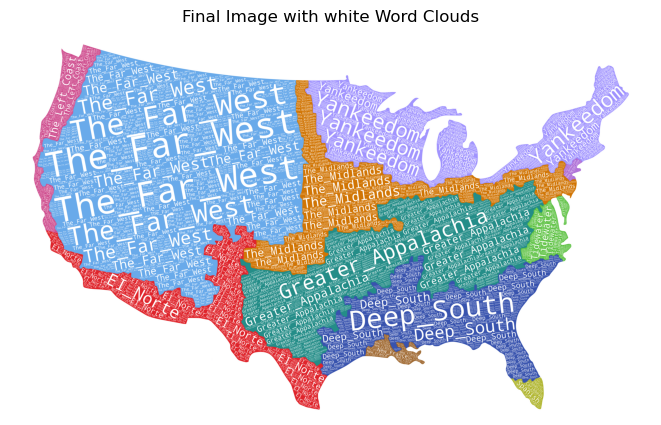

In [2]:

# Usage
image_path = 'M7_NoLegend.png'
color_text_pairs = {
    (223, 36, 43): 'EI_Norte',
    (56, 83, 174): 'Deep_South',
    (36,141,136):'Greater_Appalachia',
    (153,94,34):'New_France',
    (167,97,211):'New_Netherland',
    (167,173,23):'Spanish Caribbean',
    (105,170,234):'The_Far_West',
    (207,78,143):'The_Left_Coast',
    (209,117,4):'The_Midlands',
    (85,191,57):'Tidewater',
    (161,148,254):'Yankeedom'
}

generate_rotated_wordclouds(image_path, color_text_pairs)